In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score$
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Paths
data_dir = 'chest-xray'

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

# Adjust validation data: Add more data from the training set to the validation set
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)


In [4]:
# Calculate how many samples to move from training set to validation set
# Let's move 25% of the training data to validation
num_samples_to_move = int(0.25 * num_train_samples)

# Randomly select samples from the training set
train_indices = torch.randperm(num_train_samples).tolist()
val_indices = train_indices[:num_samples_to_move]
train_indices = train_indices[num_samples_to_move:]

# Create subsets of train and validation data
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Now, concatenate the current val_dataset with val_subset
val_dataset_combined = torch.utils.data.ConcatDataset([val_subset, val_dataset])

In [5]:
# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_combined, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset info
print(f"Train: {len(train_subset)}, Val: {len(val_dataset_combined)}, Test: {len(test_dataset)}")
print("Classes:", train_dataset.class_to_idx)  # {'NORMAL': 0, 'PNEUMONIA': 1}


Train: 3912, Val: 1320, Test: 624
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
# Load DenseNet and adjust for binary classification
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/mayuri/PycharmProjects/Lab0/pythonProject/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mayuri/PycharmProjects/Lab0/pythonProject/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Training function without early stopping
def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_f1 = f1_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

In [10]:
# Test evaluation with confusion matrix
def evaluate_model(model, model_path="best_model.pth"):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n Test Accuracy: {acc*100:.2f}%")
    print(f"Test F1 Score: {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Epoch 1/5 | Loss: 18.4445 | Val Acc: 96.97% | Val F1: 0.9792
Epoch 2/5 | Loss: 9.1847 | Val Acc: 96.89% | Val F1: 0.9787
Epoch 3/5 | Loss: 7.2127 | Val Acc: 97.20% | Val F1: 0.9808
Epoch 4/5 | Loss: 6.9733 | Val Acc: 97.35% | Val F1: 0.9819
Epoch 5/5 | Loss: 5.8156 | Val Acc: 98.11% | Val F1: 0.9868

🎯 Test Accuracy: 86.38%
🎯 Test F1 Score: 0.9015

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.64      0.78       234
   PNEUMONIA       0.82      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.91      0.82      0.84       624
weighted avg       0.89      0.86      0.86       624



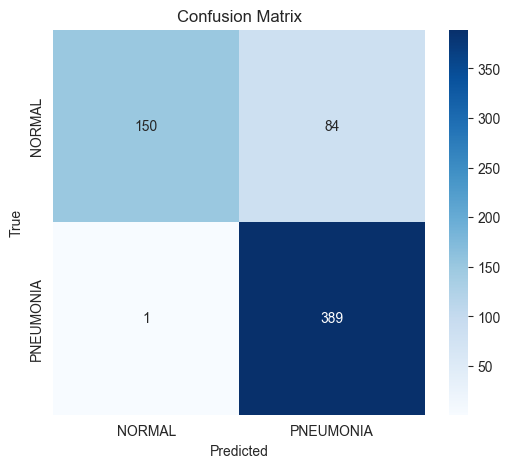

In [11]:
# Run training and evaluation
train_model(model, epochs=5)
evaluate_model(model)